C:\Users\otkul\code\quantumreservoirpy\quantumreservoirpy\reservoirbase.py:78: UserWarning: Argument 'backend' must inherit from qiskits abstract 'Backend'. Using 'aer_simulator' instead
  warnings.warn(


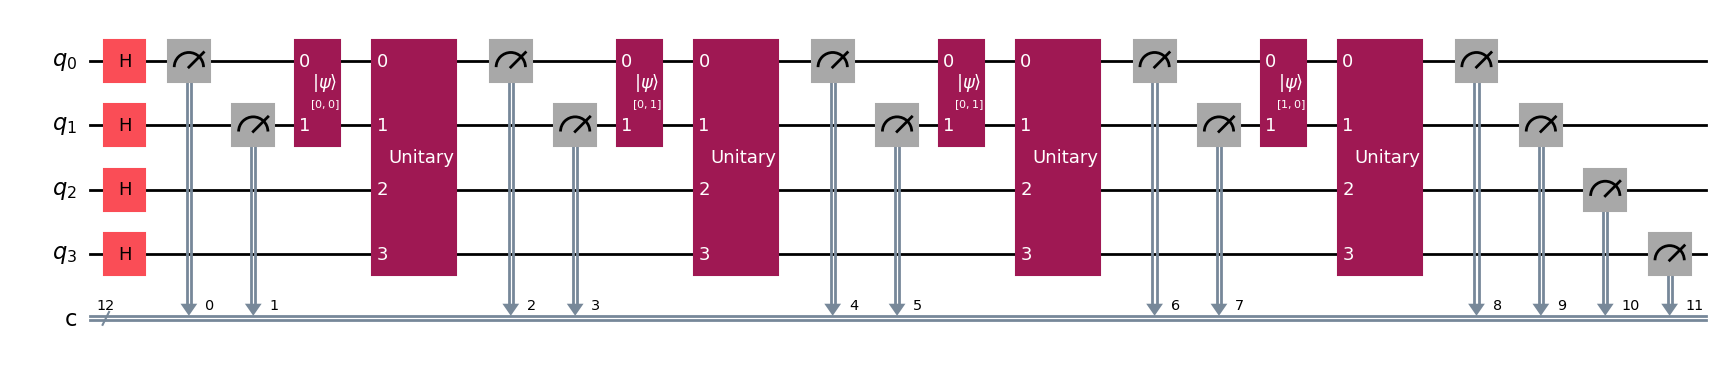

In [1]:
import numpy as np

# from qiskit import Aer
from qiskit.quantum_info import random_unitary
from quantumreservoirpy.reservoirs import Static, Incremental

encoder = {0: "00", 1: "01", 2: "10", 3: "11"}
SHOTS = 10000


class RandomUnitary(Incremental):
    def __init__(self, n_qubits, memory=np.inf, backend=None, num_features=8) -> None:
        super().__init__(n_qubits, memory, backend, num_features)
        self.operator = random_unitary(2**n_qubits)

    def before(self, circuit):
        circuit.h(circuit.qubits)

    def during(self, circuit, timestep, reservoirnumber):
        circuit.measure([0, 1])
        circuit.initialize(encoder[timestep], [0, 1])
        circuit.append(self.operator, circuit.qubits)

    def after(self, circuit):
        circuit.measure_all()


res = RandomUnitary(n_qubits=4, memory=8)

timestep = [0, 1, 2, 3, 0, 1, 2, 2, 3]
timeseries = timestep * 10

res.circuit([0, 1, 1, 2], merge_registers=True).draw("mpl")

In [2]:
states = res.run(timeseries, shots=SHOTS)

Analyzing... : 100%|██████████| 90/90 [01:25<00:00,  1.05it/s] 


In [3]:
warmup = 0.1
warmup_len = int(len(states) * warmup)
xstates = states[:-1][warmup_len:]
target = timeseries[1:][warmup_len:]

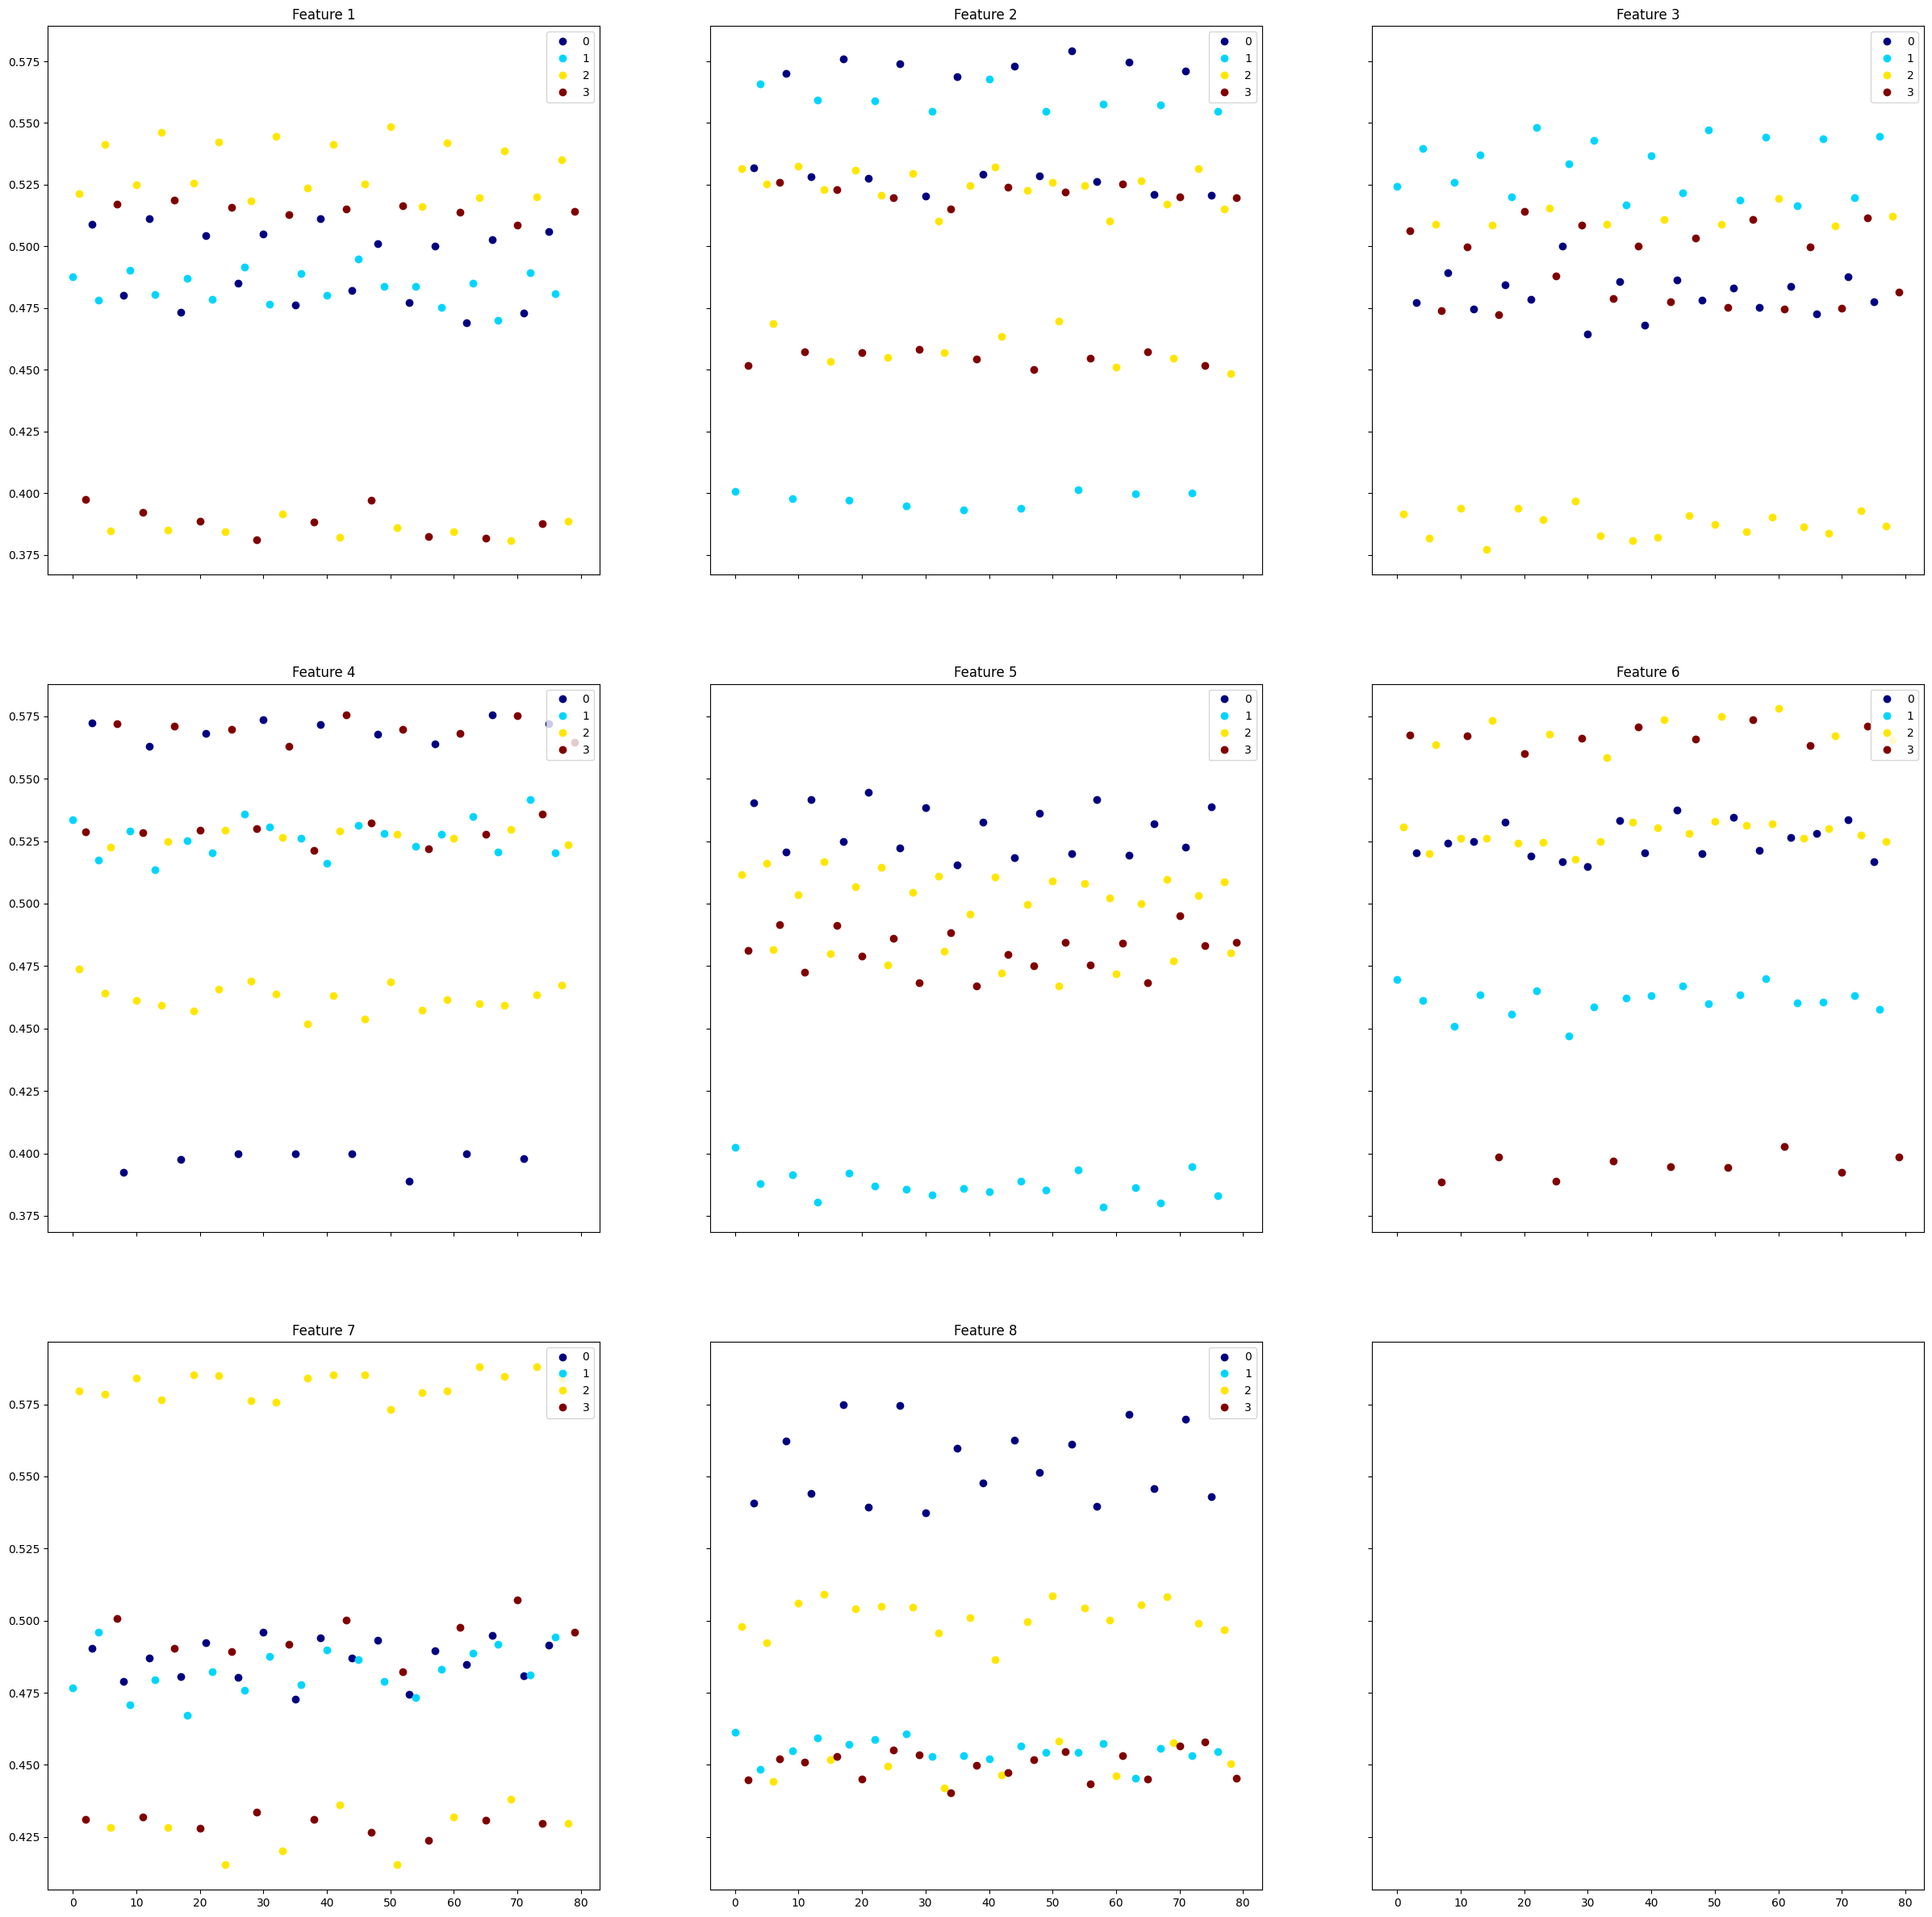

In [4]:
from quantumreservoirpy.plot import state_plotter

fig, ax = state_plotter(xstates, target)

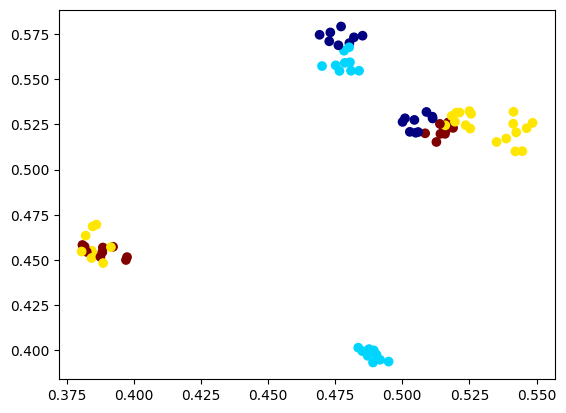

In [5]:
import matplotlib.pyplot as plt
import numpy as np

cmap = plt.get_cmap("jet", len(np.unique(timeseries)))
plt.scatter(xstates[:, 0], xstates[:, 1], cmap=cmap, c=target)

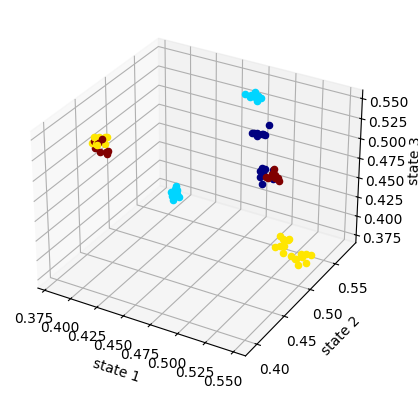

In [6]:
if xstates.shape[-1] >= 3:

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    cmap = plt.get_cmap("jet", len(np.unique(timeseries)))
    for i, x, y, z in zip(target, xstates[:, 0], xstates[:, 1], xstates[:, 2]):
        ax.scatter(x, y, z, color=cmap(i))
    ax.set_xlabel("state 1")
    ax.set_ylabel("state 2")
    ax.set_zlabel("state 3")

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

num_pred = 20

model = KNeighborsClassifier(n_neighbors=1)
X_train, X_test, y_train, y_test = train_test_split(
    xstates, target, test_size=0.33, random_state=42
)

model.fit(X_train, y_train)
print(model.score(X_test, y_test))

model.fit(xstates, target)

0.9259259259259259


,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [8]:
predictions = res.predict(num_pred=40, model=model, from_series=timeseries, shots=SHOTS)

Predicting...: 100%|██████████| 40/40 [00:19<00:00,  2.04it/s]


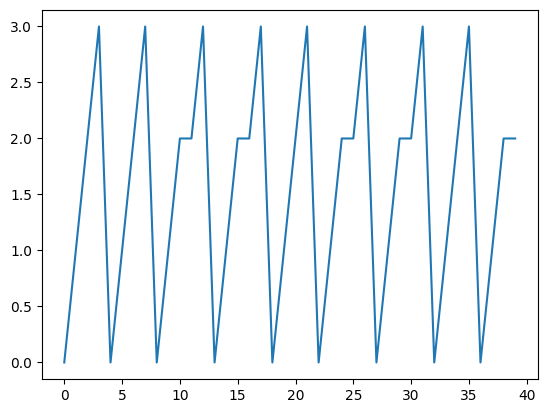

In [9]:
plt.plot(predictions)